In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv("data.csv")

metadata_cols = ["country", "currency", "price_perception", "average_rental_price"]
metadata = df[metadata_cols]
metadata = metadata.values.repeat(30, axis=0)

prices_cols = ["kg", "price"]
prices = df.values[:, 8:].reshape(-1, 2)

products = np.array(["apples", "bananas", "tomatoes", "potatoes", "flour", "rice", "milk", "butter", "eggs", "chicken"])
products = products.repeat(3).reshape(-1, 1).repeat(50, axis=1).T.reshape(-1, 1)

df = pd.DataFrame()
df[metadata_cols] = metadata
df["product"] = products
df[prices_cols] = prices

df = df.dropna()
df.head()

,country,currency,price_perception,average_rental_price,product,kg,price
0,Germany,EUR,Budget (cheap),826,apples,2.0,2.22
1,Germany,EUR,Budget (cheap),826,apples,1.0,2.99
2,Germany,EUR,Budget (cheap),826,apples,1.0,1.49
3,Germany,EUR,Budget (cheap),826,bananas,1.0,3.9
4,Germany,EUR,Budget (cheap),826,bananas,1.0,1.59


In [11]:
# standardize city names
replacements = [
    [["berlin", "germany"], "berlin"],
    [["kingdom", "kindom", "uk", "london"], "london"],
    [["seoul"], "seoul"],
    [["states"], "san_francisco"],
]

for unique_val in df.country.unique():
    for matches, replacement in replacements:
        if any(s in unique_val.lower() for s in matches):
            df.country.replace(unique_val, replacement, inplace=True)

print(df.country.unique())

# shorten names
df.replace({"price_perception": {"Budget (cheap)": "cheap", "Mid-range": "mid", "Luxury (expensive)": "high"}}, inplace=True)
df.rename(columns={"price_perception": "brand", "average_rental_price": "rent", "country": "city"}, inplace=True)

['berlin' 'seoul' 'london' 'san_francisco']


In [12]:
# source: google
euro_per_dollar = 0.92
won_per_dollar = 1232
gbp_per_dollar = 0.76

currency_conversion = np.ones(len(df))
currency_conversion[df["currency"] == "EUR"] = euro_per_dollar
currency_conversion[df["currency"] == "GBP"] = gbp_per_dollar
currency_conversion[df["currency"] == "KRW"] = won_per_dollar

# perform currency adjustment
df["price_usd"] = df["price"] / currency_conversion

# control for quantity
df["dpkg"] = df["price_usd"] / df["kg"]
df = df[["product", "city", "brand", "rent", "dpkg"]]

df.head()

,product,city,brand,rent,dpkg
0,apples,berlin,cheap,826,1.206522
1,apples,berlin,cheap,826,3.25
2,apples,berlin,cheap,826,1.619565
3,bananas,berlin,cheap,826,4.23913
4,bananas,berlin,cheap,826,1.728261


In [13]:
cities = pd.get_dummies(df.city)
brands = pd.get_dummies(df.brand)
products = pd.get_dummies(df["product"])

In [14]:
with pm.Model() as model:
    # random variables represent unknown price multipliers
    city_coeffs = pm.Gamma("city_coeffs", alpha=1, beta=1, shape=cities.shape[1])
    brand_coeffs = pm.Gamma("brand_coeffs", alpha=1, beta=1, shape=brands.shape[1])
    product_coeffs = pm.Gamma("product_coeffs", alpha=1, beta=1, shape=products.shape[1])

    # calculate effects for our data
    city_effects = cities.values @ city_coeffs
    brand_effects = brands.values @ brand_coeffs
    product_effects = products.values @ product_coeffs

    # add gaussian noise
    observation_noise = pm.Gamma("price_noise", 1, 1)
    price_observed = pm.Normal(
        "observed_price",
        mu=city_effects*brand_effects*product_effects,
        sigma=observation_noise,
        observed=df.dpkg.values
    )

    # perform sampling
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

In [21]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

dims = 10
true_stddev = tf.sqrt(tf.linspace(1., 3., dims))
likelihood = tfd.MultivariateNormalDiag(loc=0., scale_diag=true_stddev)

states = tfp.mcmc.sample_chain(
    num_results=1000,
    num_burnin_steps=500,
    current_state=tf.zeros(dims),
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=likelihood.log_prob,
      step_size=0.5,
      num_leapfrog_steps=2),
    trace_fn=None)

sample_mean = tf.reduce_mean(states, axis=0)
# ==> approx all zeros

sample_stddev = tf.sqrt(tf.reduce_mean(
    tf.squared_difference(states, sample_mean),
    axis=0))
# ==> approx equal true_stddev

AttributeError: module 'tensorflow' has no attribute 'squared_difference'

In [91]:
data = np.random.exponential(scale=5, size=5000)
model = tfd.Gamma(2, 5)

kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=model.log_prob,
    step_size=0.5,
    num_leapfrog_steps=2
)
kernel = tfp.mcmc.SimpleStepSizeAdaptation(kernel, num_adaptation_steps=400)

samples = tfp.mcmc.sample_chain(
    num_results=3000,
    num_burnin_steps=500,
    current_state=10.,
    kernel=kernel,
    trace_fn=None).numpy()

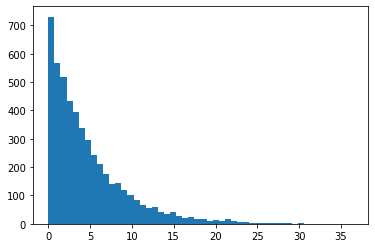

In [92]:
plt.hist(data, bins=50)
plt.show()

array([0.0505017 , 1.22756886])

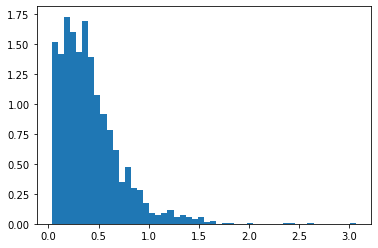

In [93]:
plt.hist(samples, density=True, bins=50)
np.quantile(samples, [0.025, 0.975])